In [53]:
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

%matplotlib inline
device = "cpu"

random.seed(16)
np.random.seed(16)
torch.manual_seed(16)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, file, scaler):
        self.df = pd.read_csv(file)
        self.scaler = scaler
        self.features = ['x1', 'x2']

    # number of rows in the data
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = self.df.iloc[index:index+1][self.features]
        y = self.df.iloc[index]['label']
        x_scaled = self.scaler.transform(x)
        return (torch.FloatTensor(x_scaled).squeeze(), torch.tensor(y, dtype=torch.long))
    
class FFNN(nn.Module):
    def __init__(self, input_size, output_size, num_nodes):
        super(FFNN, self).__init__()
        self.num_nodes = num_nodes
        self.linear1 = nn.Linear(input_size, self.num_nodes, bias=True)
        self.relu1 = nn.LeakyReLU()
        self.linear_out = nn.Linear(self.num_nodes, output_size, bias=True)
       # self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear_out(x)
        #x = self.sigmoid(x)
        return x

def train(dataloader, model, loss_function, optim):
    model.train()
    for (x,y) in dataloader:
        pred = model(x) # get predictions
        loss = loss_function(pred, y) # evaluate performance
        optim.zero_grad() # discard old gradients from previous batches
        loss.backward() # calculate new gradients
        optim.step() # update weights using new gradients

def test(dataloader, model, loss_function):
    model.eval()
    avg_loss = 0
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            avg_loss += loss_function(pred, y).item()
            num_samples += y.size(0)
            _, predicted = torch.max(pred, 1)

            #binary_prediction = (pred >= 0.5).float()
            #num_correct += (binary_prediction == y).sum().item()

            if predicted.item() == y.item():
                num_correct += 1

    accuracy = num_correct / num_samples
    return avg_loss / num_samples, accuracy
     


In [54]:
scaler = MinMaxScaler()
train_df = pd.read_csv('spiral_train.csv')
scaler.fit(train_df[['x1', 'x2']])

train_data = Dataset('spiral_train.csv', scaler)
test_data = Dataset('spiral_test.csv', scaler)
valid_data = Dataset('spiral_valid.csv', scaler)

train_loader = DataLoader(train_data, batch_size=1) 
test_loader = DataLoader(test_data, batch_size=1)
valid_loader = DataLoader(valid_data, batch_size=1)

In [55]:
nodes = [3]
loss_function = nn.CrossEntropyLoss()
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
models = []

for i in range(len(nodes)):
    # Setup
    model = FFNN(2,2,nodes[i])
    optim = torch.optim.Adam(model.parameters(), lr= 1e-2)
    epochs = 30
    train_losses_node_i = []
    train_accuracies_node_i = []

    valid_losses_node_i = []
    valid_accuracies_node_i = []

    # Train the model and gather train loss and accuracy data
    for _ in range(epochs):
        train(train_loader, model, loss_function, optim)
        train_losses_node_i.append(test(train_loader, model, loss_function)[0])
        train_accuracies_node_i.append(test(train_loader, model, loss_function)[1])

        valid_losses_node_i.append(test(valid_loader, model, loss_function)[0])
        valid_accuracies_node_i.append(test(valid_loader, model, loss_function)[1])

    print(f"{nodes[i]} nodes test accuracy: {test(test_loader, model, loss_function)[1]}")

    train_losses.append(train_losses_node_i)
    train_accuracies.append(train_accuracies_node_i)
    valid_losses.append(valid_losses_node_i)
    valid_accuracies.append(valid_accuracies_node_i)
    models.append(model)



3 nodes test accuracy: 0.8


Text(0.5, 0.98, 'Spiral - 3 Nodes- Non-Regularized')

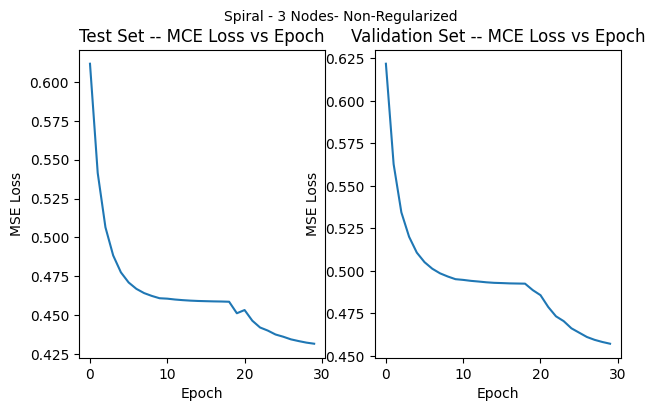

In [56]:
# Plotting
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1) 
node_index = 0

x_vals = range(len(train_losses[node_index]))
y_vals = train_losses[node_index]
plt.plot(x_vals, y_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Set -- MCE Loss vs Epoch")

plt.subplot(1, 2, 2)  
x_vals = range(len(valid_losses[node_index]))
y_vals = valid_losses[node_index]
plt.plot(x_vals, y_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Validation Set -- MCE Loss vs Epoch")
name = "Spiral - 3 Nodes- Non-Regularized"
plt.suptitle(name, fontsize = 10)

1. Cross Entropy Loss
a. list hyper-parameters used in the model, 

Learning rate: 1e-2, Number of epochs: 30, Activation function: leakyReLU, batch size: 1

b. plot the learning curves for training and validation loss as a function of training epochs, 

see below 

c.   provide the final text accuracy, defined as the number of correct classifications divided by 
the total number of examples, 

Center Surround - 0.74 with 9 nodes, Two Gaussians - 0.92 with 9 nodes, Spiral - 0.935 with 9 nodes, Xor - 0.915 with 9 nodes

d.   plot the learned decision surface along with observations from the test set (see example 
below), and 

see below 
e. discuss your design choices and comment on how they impact performance.

We found that increasing the learning rate had an unclear affect on performance. We found that setting a low learning rate often resulted in higher performance, but not always. We believe this can happen if the model reaches a local minimum of the loss function. Increasing the number of epochs tends to increase model performance, which can be seen in the graphs showing loss vs number of epochs blow. Decreasing the batch size decreased training time for the benefit of higher performance. We also found that increasing the number of nodes in the hidden layer almost always increased the performance of the model, also at the cost of a higher training time.

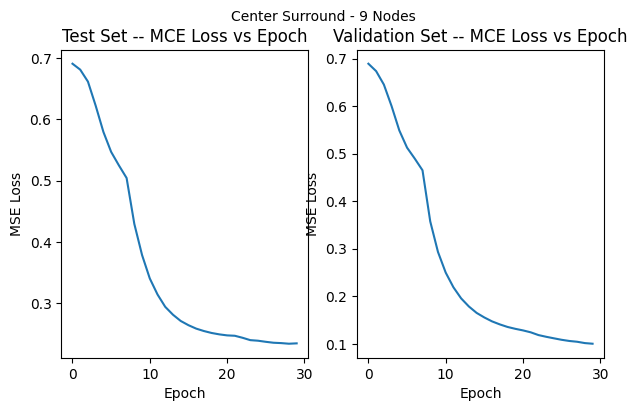
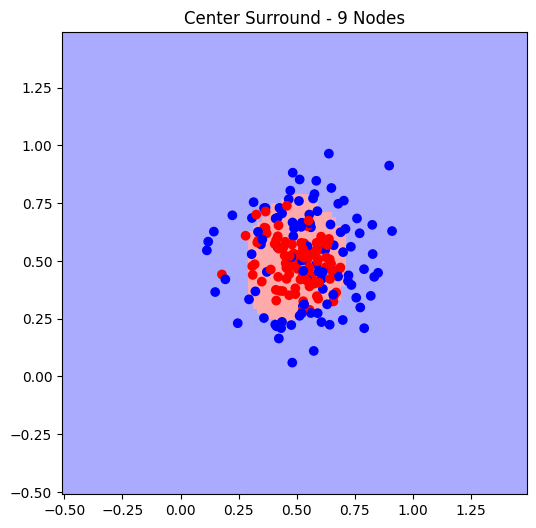
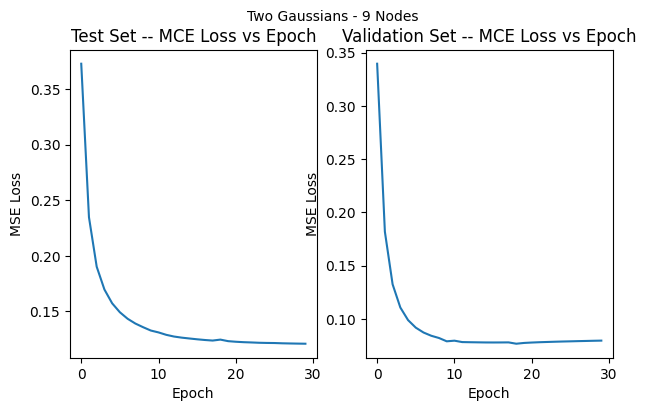
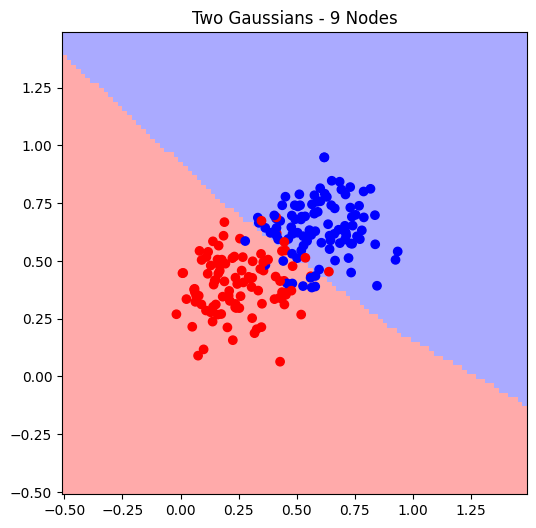
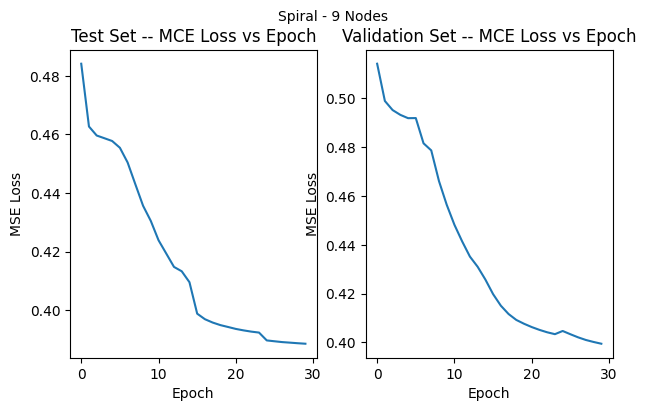
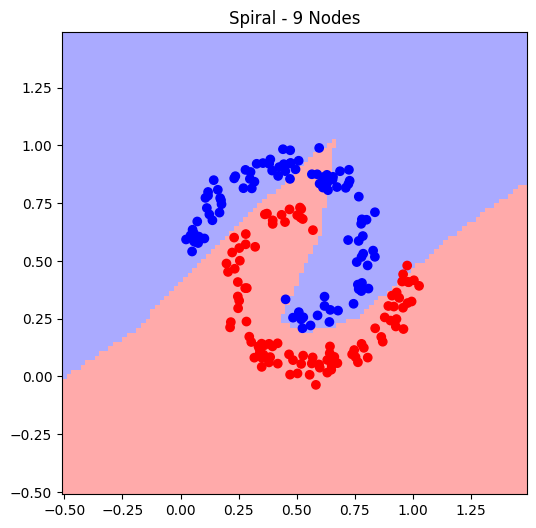
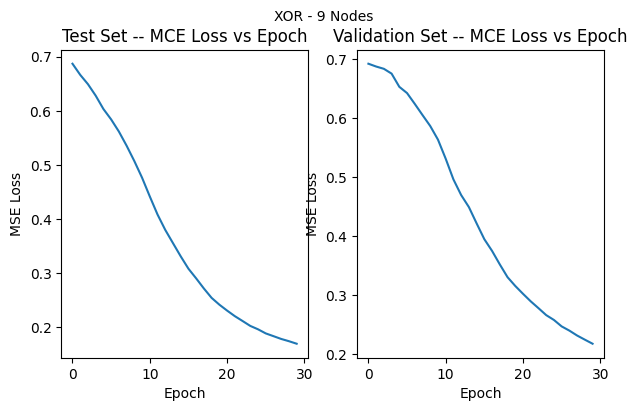
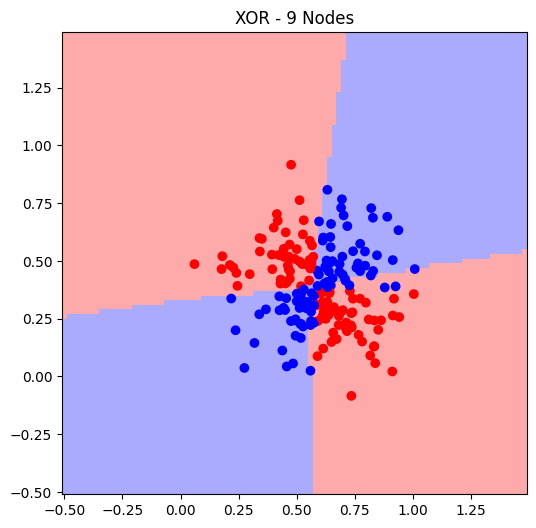

2) a. list hyper-parameters used in the model, 

For our model, we used a learning rate of 1e-2, 30 epochs, leaky ReLU, and a batch size of 1. Each of these hyperparameters were experiementally determined to achieve high performance without long run times. 

b. plot the learning curves for training and validation loss as a function of training epochs, 

see below 

c.   provide the final text accuracy, defined as the number of correct classifications divided by 
the total number of examples, 

The following classifcation accuracies were achieved on the testing sets: Two Gaussians - 0.92 with 9 nodes, Center Surround - 0.755 with 7 nodes, Spiral - 0.885 with 9 nodes, XOR - 0.895  with 9 nodes 

d.   plot the learned decision surface along with observations from the test set (see example 
below), and 

see below

e. discuss your design choices and comment on how they impact performance.

Similar impacts were seen as in part one. Making a larger batch size decreased performance, and increasing the number of nodes improved performance.


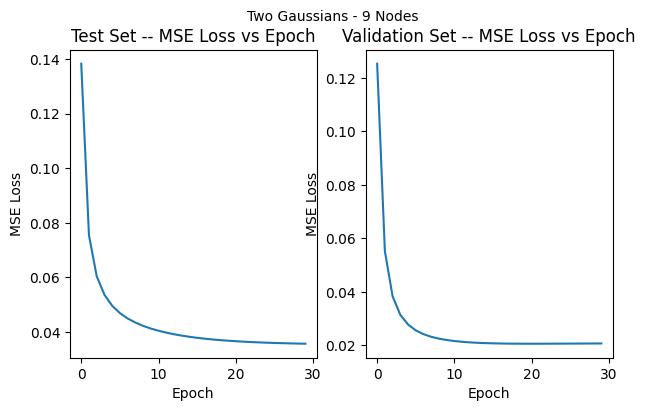
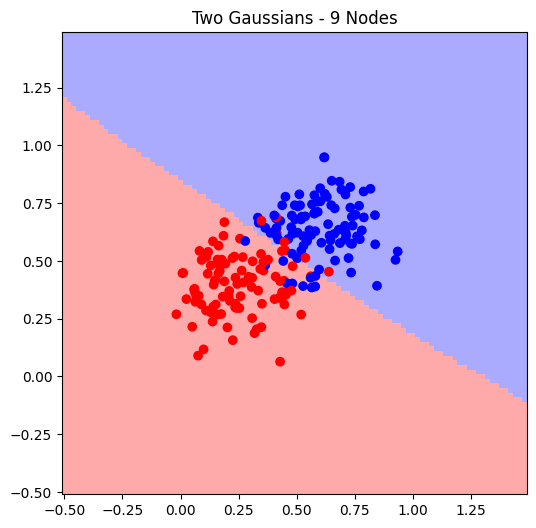
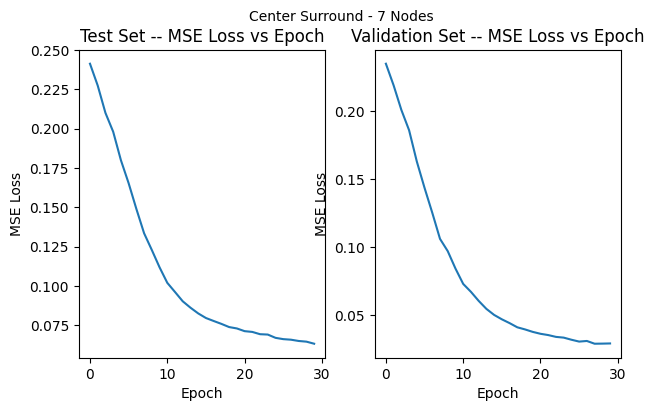
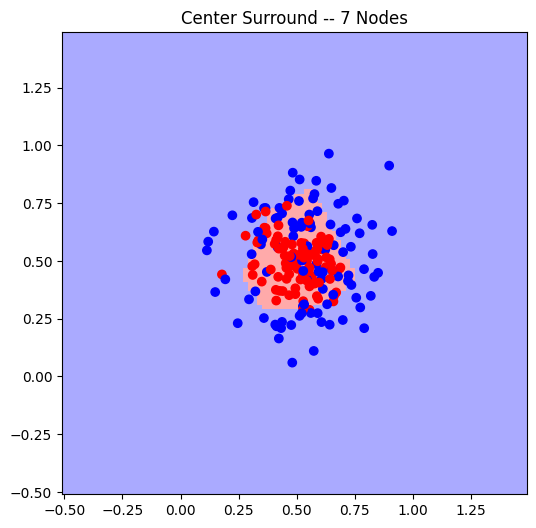
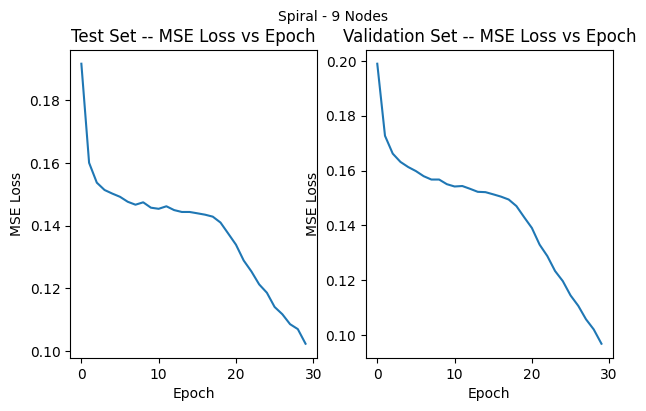
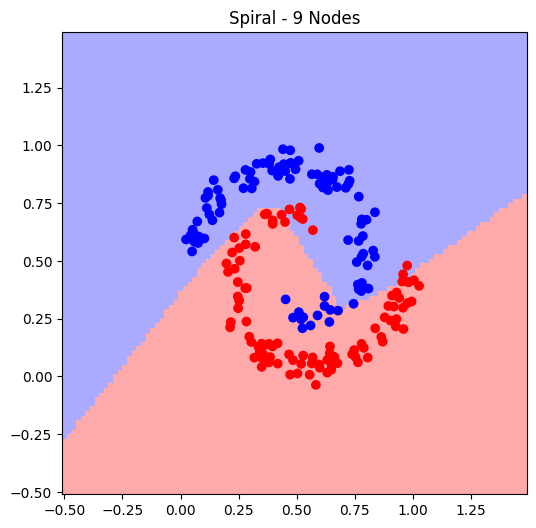
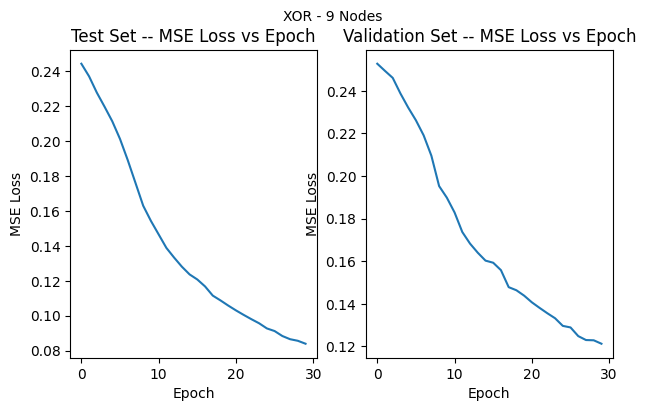
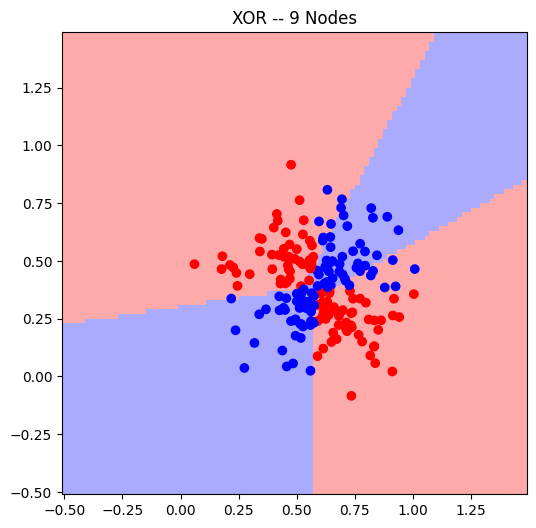


Verifying accuracy: 0.8


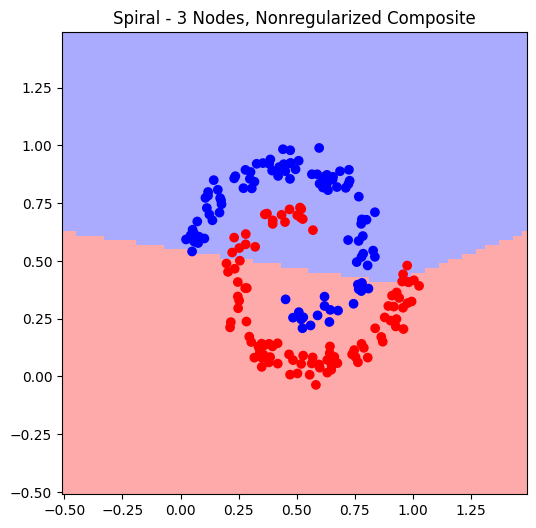

In [38]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

def draw_example(name, model, train_dataset, test_dataset, title=None):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for i in range(len(train_dataset)):
        x, y = train_dataset[i]
        train_x.append(x.numpy())
        train_y.append(y.numpy())
    
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        test_x.append(x.numpy())
        test_y.append(y.numpy())
    
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    h = .02
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5
    y_min, y_max = train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.FloatTensor(grid_points)
    
    with torch.no_grad():
        outputs = model(grid_points)
        _, predicted = torch.max(outputs.data, 1)
        Z = predicted.numpy()
    
    Z = Z.reshape(xx.shape)
            
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(test_x[:, 0], test_x[:, 1], c=test_y.squeeze(), cmap=cmap_bold)
    
    ax.set_title(name)


print(f"Verifying accuracy: {test(test_loader, models[0], loss_function)[1]}")
draw_example("Spiral - 3 Nodes, Nonregularized Composite",models[0], train_data, test_data)


In [104]:
class manual_FFNN:
    def __init__(self, input_size, output_size, num_nodes, learning_rate):
        # random weights and biases
        self.W1 = np.random.rand(input_size, num_nodes) 
        self.bias1 = np.random.rand(1, num_nodes) 
        self.W2 = np.random.rand(num_nodes, output_size) 
        self.bias2 = np.random.rand(1, output_size) 
        self.learning_rate = learning_rate

    def leaky_relu(self, x):
        return np.where(x >= 0, x, x/100)
    
    def leaky_relu_prime(self, x):
        return np.where(x >= 0, 1, 1/100)

    def forward(self, x):
        # pass through the steps
        self.x = x.reshape(1,-1)
        self.q = np.dot(self.x, self.W1) + self.bias1
        self.h = self.leaky_relu(self.q)
        self.z = np.dot(self.h, self.W2) + self.bias2
        return self.z
    

    def backward(self, x, y):
        x= x.reshape(1,-1)

        y_resize = np.zeros((1,2)) # model outputs probabilities of each class, so we need that shape
        y_resize[0, y] = 1

        dz = self.forward(x) - y_resize
        
        dh = np.zeros_like(self.h)
        for i in range(self.h.shape[1]):
            for j in range(2):
                dh[0,i] += dz[0,j] * self.W2[i,j]
        dh = dh * self.leaky_relu_prime(self.q)
        
        dW2 = np.zeros_like(self.W2)
        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                dW2[i,j] = self.h[0,i] * dz[0,j]
             
        dW1 = np.zeros_like(self.W1)
        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                dW1[i,j] = self.x[0,i] * dh[0,j]

        dBias2 = dz
        dBias1 = dh
    
        self.W1 -= dW1 * self.learning_rate
        self.bias1 -= dBias1 * self.learning_rate
        self.W2 -= dW2 * self.learning_rate
        self.bias2 -= dBias2 * self.learning_rate

In [105]:
scaler = MinMaxScaler()
train_df = pd.read_csv('xor_train.csv')
test_df = pd.read_csv('xor_test.csv')

y_train = train_df['label']
x_train = scaler.fit_transform(train_df[['x1', 'x2']])
y_test = test_df['label']
x_test = scaler.transform(test_df[['x1', 'x2']])

def train_manual_FFNN(x_train, y_train, num_nodes, num_epochs, learning_rate):
    loss_func = nn.CrossEntropyLoss()
    model = manual_FFNN(2,2,num_nodes,learning_rate)
    losses = []
    for e in range(num_epochs):
        epoch_loss = 0
        for i in range(len(x_train)):
            x = x_train[i]
            y = int(y_train[i])

            output = model.forward(x)
            output = torch.tensor([output]).reshape(1,-1)
            y_tensor = torch.tensor([y])
            loss = loss_func(output, y_tensor)
            epoch_loss += float(loss)

            model.backward(x,y)
        epoch_loss = epoch_loss / len(x_train) # just need avg
        losses.append(epoch_loss)
    return model, losses

def test_manual(model, x_test, y_test):
    correct = 0
    for i in range(len(x_test)):
        x = x_test[i]
        y = int(y_test[i])
        output = model.forward(x)
        prediction = np.argmax(output) # get the index corresponding to the highest output
        if prediction == y:
            correct += 1 
    accuracy = correct / len(x_test)
    print(f"Test Accuracy: {accuracy:.3f}")
    return accuracy

In [ ]:
model, losses = train_manual_FFNN(x_train, y_train, 9, 30, 1e-2)

# Plotting
plt.figure(figsize=(7, 4))
node_index = 4

x_vals = range(epochs)
y_vals = losses
plt.plot(x_vals, y_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Set -- MCE Loss vs Epoch, 9 Nodes")


In [61]:
class FFNN_regularized(nn.Module):
    def __init__(self, input_size, output_size, num_nodes):
        super(FFNN_regularized, self).__init__()
        self.num_nodes = num_nodes
        self.linear1 = nn.Linear(input_size, self.num_nodes, bias=True)
        self.relu1 = nn.LeakyReLU()
        self.linear_out = nn.Linear(self.num_nodes, output_size, bias=True)
       # self.sigmoid = nn.Sigmoid()

    def norm_regularization(self, x):
        return torch.norm(self.linear1.weight, p=2)

    def orthogonal_regularization(self, x):
        weights = self.linear1.weight
        W_Wt = torch.mm(weights, weights.t())
        eye = torch.eye(W_Wt.shape[0])
        orth_reg = torch.norm(W_Wt - eye)
        return orth_reg

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear_out(x)
        #x = self.sigmoid(x)
        return x

def train(dataloader, model, loss_function, optim):
    model.train()
    for (x,y) in dataloader:
        pred = model(x) # get predictions
        loss = loss_function(pred, y) + model.orthogonal_regularization(x) + (model.norm_regularization(x) / 10)# evaluate performance
        optim.zero_grad() # discard old gradients from previous batches
        loss.backward() # calculate new gradients
        optim.step() # update weights using new gradients

def test(dataloader, model, loss_function):
    model.eval()
    avg_loss = 0
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            avg_loss += loss_function(pred, y).item()
            num_samples += y.size(0)
            _, predicted = torch.max(pred, 1)

            #binary_prediction = (pred >= 0.5).float()
            #num_correct += (binary_prediction == y).sum().item()

            if predicted.item() == y.item():
                num_correct += 1

    accuracy = num_correct / num_samples
    return avg_loss / num_samples, accuracy

In [62]:
scaler = MinMaxScaler()
train_df = pd.read_csv('spiral_train.csv')
scaler.fit(train_df[['x1', 'x2']])

train_data = Dataset('spiral_train.csv', scaler)
test_data = Dataset('spiral_test.csv', scaler)
valid_data = Dataset('spiral_valid.csv', scaler)

train_loader = DataLoader(train_data, batch_size=1) 
test_loader = DataLoader(test_data, batch_size=1)
valid_loader = DataLoader(valid_data, batch_size=1)

loss_function = nn.CrossEntropyLoss()
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model = FFNN_regularized(2,2,3)
optim = torch.optim.Adam(model.parameters(), lr= 1e-2)
epochs = 30
train_losses_node_i = []
train_accuracies_node_i = []

valid_losses_node_i = []
valid_accuracies_node_i = []

for _ in range(epochs):
    train(train_loader, model, loss_function, optim)
    train_losses_node_i.append(test(train_loader, model, loss_function)[0])
    train_accuracies_node_i.append(test(train_loader, model, loss_function)[1])

    valid_losses_node_i.append(test(valid_loader, model, loss_function)[0])
    valid_accuracies_node_i.append(test(valid_loader, model, loss_function)[1])

print(f"3 nodes test accuracy: {test(test_loader, model, loss_function)[1]}")



3 nodes test accuracy: 0.795


Text(0.5, 0.98, 'Spiral - 3 Nodes - Regularized')

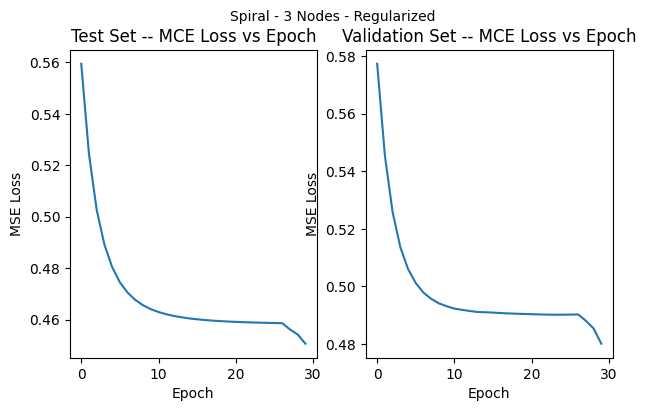

In [63]:
# Plotting
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1) 
node_index = 4

x_vals = range(len(train_losses_node_i))
y_vals = train_losses_node_i
plt.plot(x_vals, y_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Set -- MCE Loss vs Epoch")

plt.subplot(1, 2, 2)  
x_vals = range(len(valid_losses_node_i))
y_vals = valid_losses_node_i
plt.plot(x_vals, y_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Validation Set -- MCE Loss vs Epoch")
name = "Spiral - 3 Nodes - Regularized"
plt.suptitle(name, fontsize = 10)

Verifying accuracy: 0.795


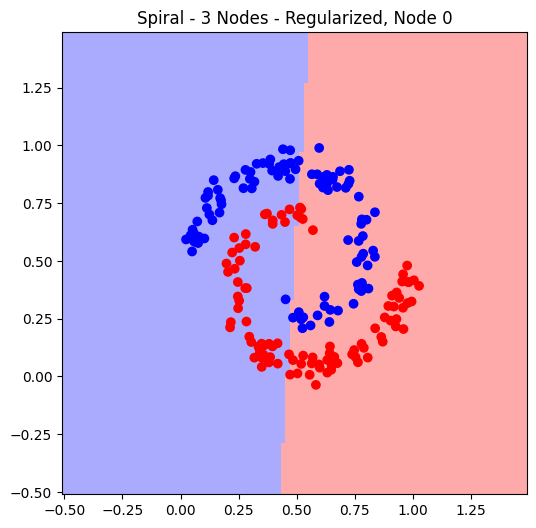

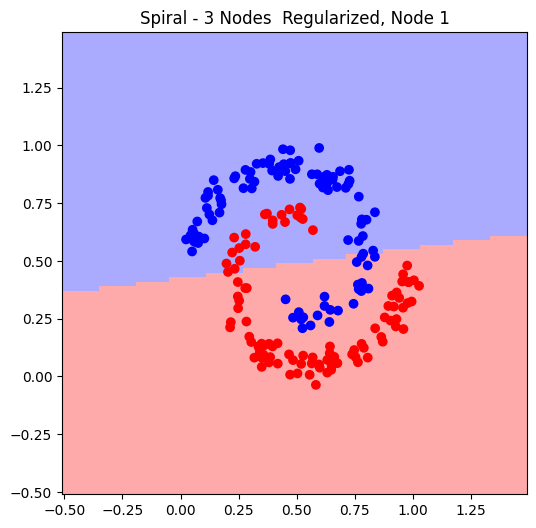

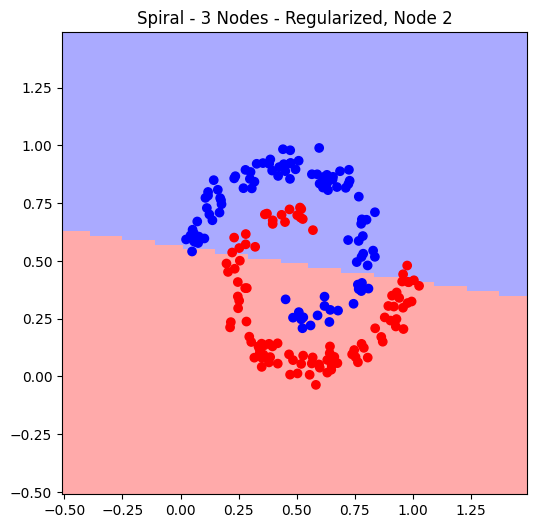

In [66]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

def draw_example(name, model, train_dataset, test_dataset, node):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for i in range(len(train_dataset)):
        x, y = train_dataset[i]
        train_x.append(x.numpy())
        train_y.append(y.numpy())
    
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        test_x.append(x.numpy())
        test_y.append(y.numpy())
    
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    h = .02
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5
    y_min, y_max = train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.FloatTensor(grid_points)
    
    with torch.no_grad():
        weight = model.linear1.weight[node]
        bias = model.linear1.bias[node]

        outputs = torch.mm(grid_points,weight.view(-1,1)) + bias
        Z = outputs.numpy()
    
    Z = Z.reshape(xx.shape)
            
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(test_x[:, 0], test_x[:, 1], c=test_y.squeeze(), cmap=cmap_bold)
    
    ax.set_title(name)


print(f"Verifying accuracy: {test(test_loader, model, loss_function)[1]}")
name = "Spiral - 3 Nodes - Regularized, Node 0"
draw_example(name,model, train_data, test_data, 0)
name = "Spiral - 3 Nodes  Regularized, Node 1"
draw_example(name,model, train_data, test_data, 1)
name = "Spiral - 3 Nodes - Regularized, Node 2"
draw_example(name,model, train_data, test_data, 2)


Verifying accuracy: 0.795


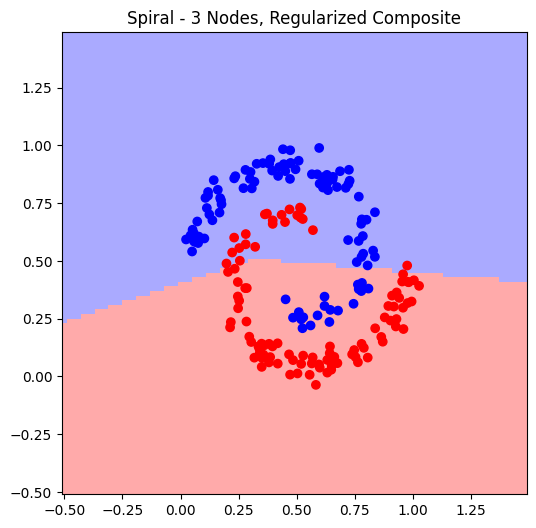

In [65]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

def draw_example(name, model, train_dataset, test_dataset):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for i in range(len(train_dataset)):
        x, y = train_dataset[i]
        train_x.append(x.numpy())
        train_y.append(y.numpy())
    
    for i in range(len(test_dataset)):
        x, y = test_dataset[i]
        test_x.append(x.numpy())
        test_y.append(y.numpy())
    
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

    h = .02
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5
    y_min, y_max = train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.FloatTensor(grid_points)
    
    with torch.no_grad():
        outputs = model(grid_points)
        _, predicted = torch.max(outputs.data, 1)
        Z = predicted.numpy()
    
    Z = Z.reshape(xx.shape)
            
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(test_x[:, 0], test_x[:, 1], c=test_y.squeeze(), cmap=cmap_bold)
    
    ax.set_title(name)


print(f"Verifying accuracy: {test(test_loader, model, loss_function)[1]}")
name = "Spiral - 3 Nodes, Regularized Composite"
draw_example(name,model, train_data, test_data)


3) For the manual network, we achieved the following average accuracies over twenty runs on the xor dataset:
2 nodes test accuracy: 0.551
3 nodes test accuracy: 0.553
5 nodes test accuracy: 0.556
7 nodes test accuracy: 0.566
9 nodes test accuracy: 0.566. We used 30 epochs, a learning rate of 1e-2, and leakyReLU as the activation function. The accuracy improves with an increasing number of nodes, but the model is much less effective than the pytorch implementation. This is likely because we are not using an advanced learning rate optimizer or any other optimizations. 

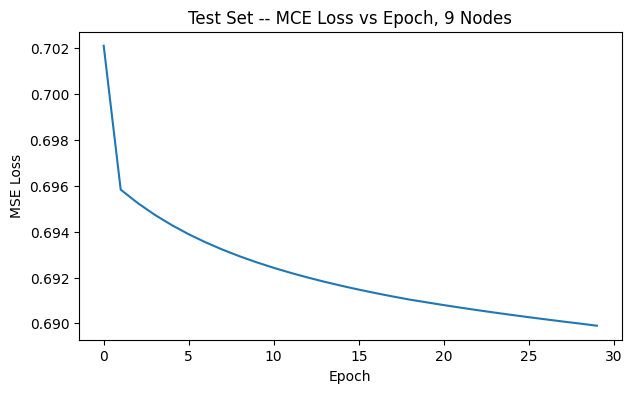

4) a. list hyper-parameters used in the model

We trained on the spiral dataset to create a model with 3-node hidden layer. To do this, we used a learning rate of 1e-2 and trained for 30 epochs. We used leaky ReLU as the activation function. The regularization coefficient, 1/100, was chosen as a balance between too weak regularization (which doesn't do anything) and too strong regularization (which prevents learning).

b. plot the learning curves for training and validation loss as a function of training epochs,

see below

c.   provide the final text accuracy, defined as the number of correct classifications divided by 
the total number of examples, 

the final accuracy of this model was 0.805. This is lower than the accuracy seen above, but that model had 9 nodes compared to this model's 3 nodes.

d.   plot the learned decision surface along with observations from the test set 

see below

e. discuss your design choices and comment on how they impact performance. 

Adding the norm regularization helped to prevent large weights from disrupting the model and prevent overfitting. The orgoonality regularization helped to force each node to learn different aspects of the data, thus giving stronger predictions.

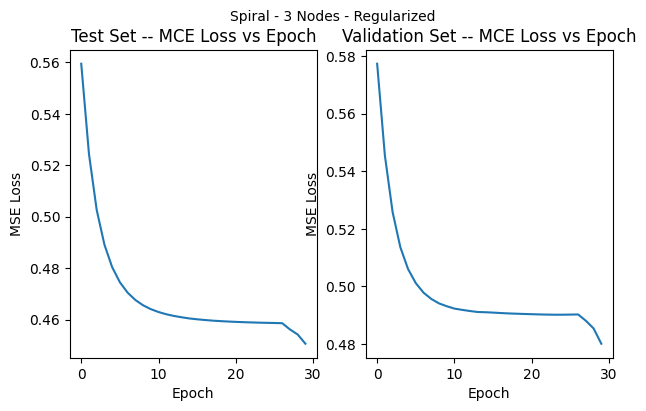
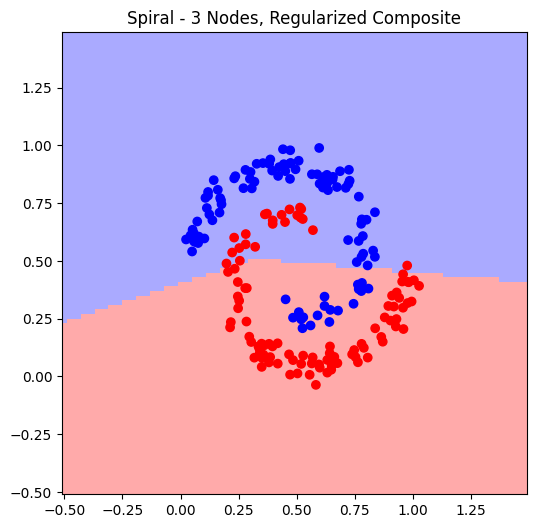
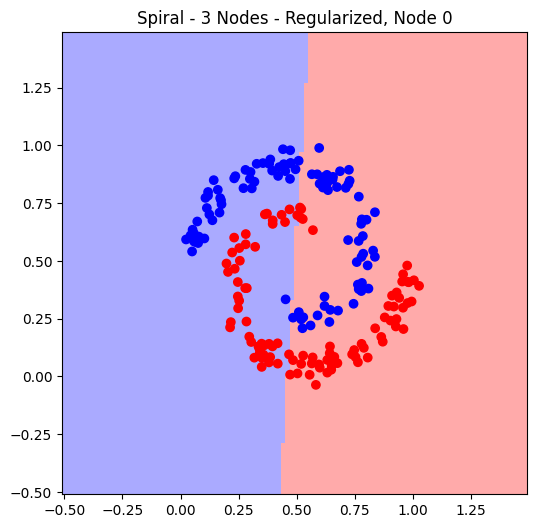
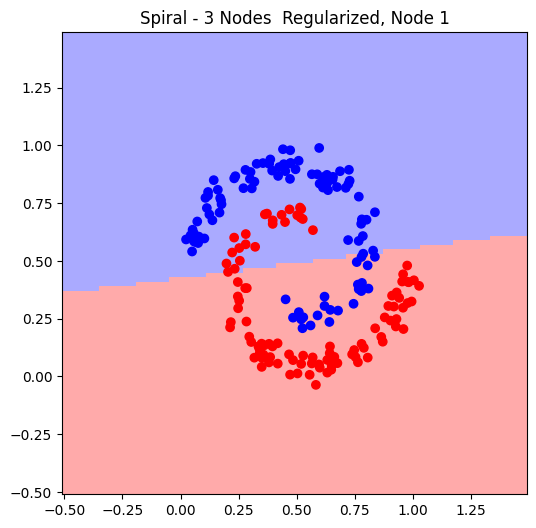
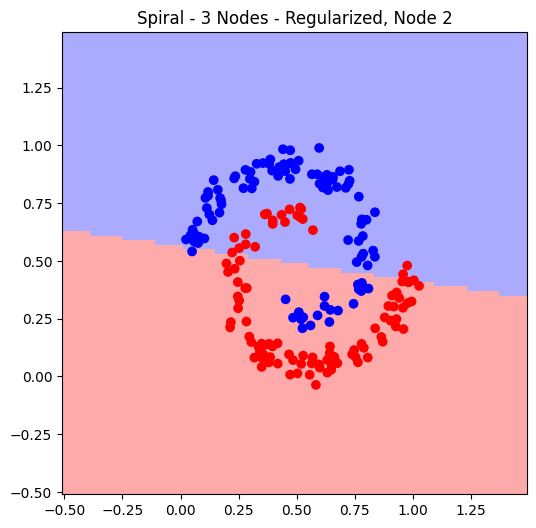


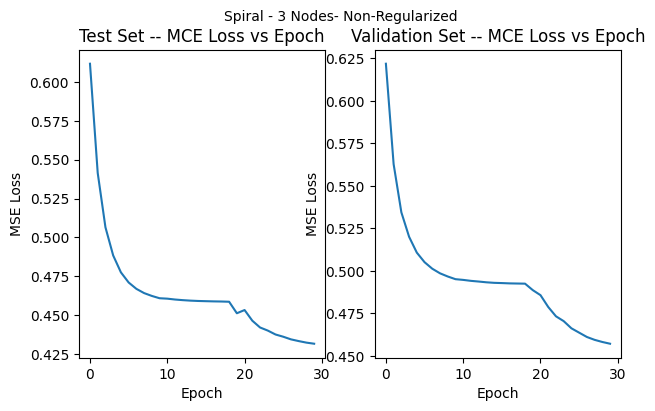
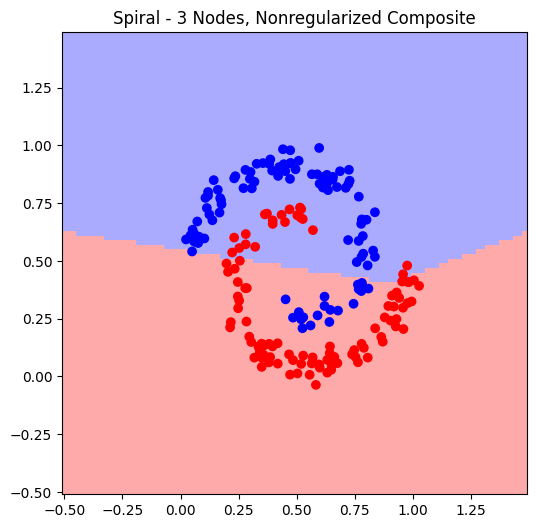
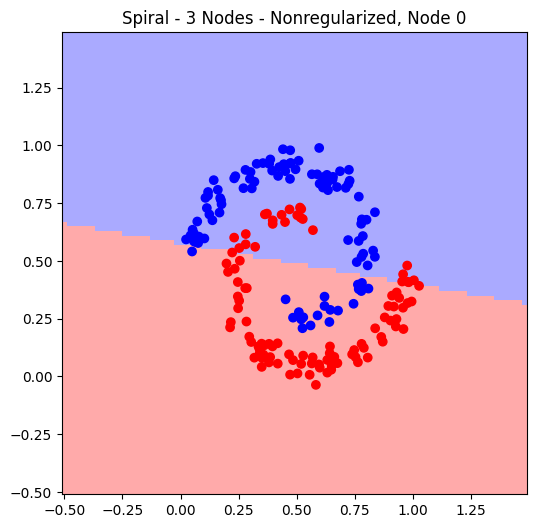
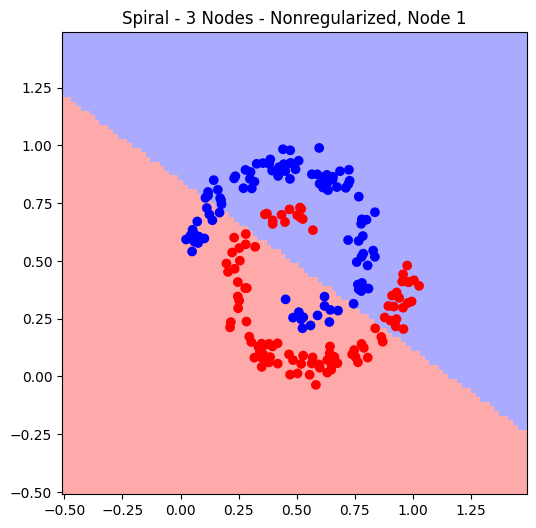
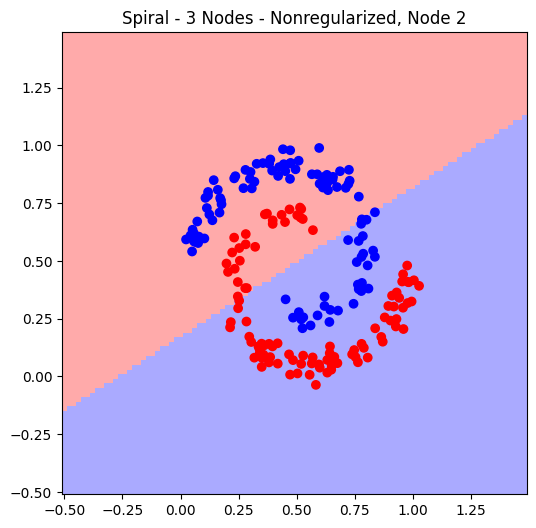